In [2]:
cd ..

/home/james/Dropbox (MIT)/All_Resourceful/localgateway/beeview_gateway


In [43]:
from algorithms import np
import pandas as pd
import itertools
import math
import functools
import numpy
import seaborn as sns
import collections
sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
})
import matplotlib.pyplot as plt
%matplotlib inline
all_data = pd.read_csv('notebook_analysis/intact_whitenoise_1_100Hz.csv')
coorddata = pd.read_csv('notebook_analysis/node_coords.csv',
                        dtype={'Node':numpy.int64},index_col='Node')

def translater(nodeax):
    node, ax = int(nodeax[0:-1]),nodeax[-1]
    translat = coorddata['Index'].to_dict()
    return translat[node]+ax
nodes = [63,41,15,95,96,53,55,31,22,17,18,56,58,61,64,43,46,49,68,32,37,39,40,69]
allnodes = [i for i in coorddata.index.tolist() if i <100]
print(allnodes)
neighborhoods = collections.defaultdict(list)
sortnodes = sorted(allnodes,key=lambda x:x%4)
neighborhoods = {k:list(g) for k,g in itertools.groupby(sortnodes, key=lambda x:x%4)}
biggest_modx = lambda lst, x: max([i for i in lst if i%4==x])
largesteach = [(i,biggest_modx(allnodes, i)) for i in range(4)]
for i,largest in largesteach:
    if i+1 in neighborhoods:
        neighborhoods[i+1].append(largest)
print(neighborhoods)

[20, 21, 22, 23, 24, 65, 25, 17, 27, 18, 29, 6, 54, 55, 56, 58, 59, 66, 60, 61, 62, 63, 64, 96, 41, 42, 43, 44, 45, 5, 46, 47, 49, 52, 53, 68, 95, 31, 32, 33, 7, 15, 36, 37, 38, 39, 40, 69]
{0: [20, 24, 56, 60, 64, 96, 44, 52, 68, 32, 36, 40], 1: [21, 65, 25, 17, 29, 61, 41, 45, 5, 49, 53, 33, 37, 69, 96], 2: [22, 18, 6, 54, 58, 66, 62, 42, 46, 38, 69], 3: [23, 27, 55, 59, 63, 43, 47, 95, 31, 7, 15, 39, 66]}


[(1, 0.0244140625),
 (2, 0.048828125),
 (3, 0.0732421875),
 (616, 15.0390625),
 (615, 15.0146484375),
 (634, 15.478515625),
 (645, 15.7470703125),
 (598, 14.599609375),
 (597, 14.5751953125),
 (640, 15.625)]

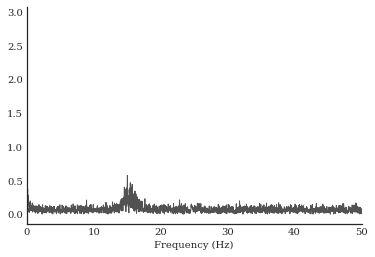

In [32]:
fig, ax= plt.subplots(1)
def get_fs(data, f):
    #eg f= 100 hz, duration =60s
    nbins = int(len(data)/2)
    nyquist = f/2
    stepsize = nyquist/nbins
    fftbins = [i*stepsize for i in range(nbins)]
    return fftbins
def maxer(fs,response):
    biggest = sorted(response,key = lambda x: abs(x), reverse=True)[:10]
    def getvals(x):
        idx = response.index(x)
        return idx, fs[idx]
    return [getvals(i) for i in biggest]
data = all_data['41x'].tolist()[0:2**12]
fft = list(map(abs, np.fft(data)))
fs = get_fs(data, 100)
ax.plot(fs, fft[0:2048], color = '#525252', linewidth=1)
ax.set_xlabel('Frequency (Hz)')
ax.set_xlim([0,50])
sns.despine()
#print('largest response at {}Hz, index{}'.format(*maxer(fs, fft[0:2048])))
maxer(fs, fft[0:2048])

In [39]:
def samplestream(nodes, all_data):
    all_idxs = (str(x)+y for x,y in itertools.product(nodes, ['x','y','z']))
    return [(x, all_data[translater(x)].tolist()[0:2**12]) for x in all_idxs]
def mapper(d):
    idx = 616
    nodeid, data = d
    ftpeak = np.fft(data)[idx]
    c = lambda d: (round(d.real,6),round(d.imag,6))
    return (0,(nodeid,c(ftpeak)))
def shuffler(kvstream):
    flat = list(kvstream)
    sortedkvs = sorted(flat, key=lambda x: x[0])
    grouped = itertools.groupby(sortedkvs, key=lambda x:x[0])
    return ((k,[i[1] for i in g]) for k,g in grouped)
def reducer(kvs):
    k,vs =kvs
    ws = [complex(*i[1]) for i in vs]
    G = np.spectral_mat(ws)
    eig = np.pagerank(G)
    c = lambda d: (round(d.real,2),round(d.imag,2))
    ms = [(vs[idx][0],c(el)) for idx,el in enumerate(eig)]
    return (k,ms)
def dmapper(neighborhoods, d):
    nodeid, data = d
    nodenum = int(nodeid[0:2])
    print(neighborhoods)
    hoods = neighborhoods[nodenum]
    idx = 616
    ftpeak = np.fft(data)[idx]
    c = lambda d: (round(d.real,6),round(d.imag,6))
    return [(i,(nodeid, c(ftpeak))) for i in hoods]

def mr(streamfun, mapfun, redfun):
    mappit = functools.partial(map, mapfun)
    reducit = functools.partial(map,redfun)
    return list(reducit(shuffler(mappit(streamfun()))))
def merger(lst):
    accer = lambda acc, el: acc+el[1]
    return functools.reduce(accer, lst,[])
def dfdd_merger(lst):
    """for example [('0',[('a',(1,2)),('b',(3,4))],
                    ('1',[('b',(2,3)),('c',(4,5))]) -? to equalise bs, must subtract (1,1) from everything in 2
                    ]
    should return [('a',(1,2)),('b',(3,4)),('c',(3+4))
    """
    def accer(acc, el):
        def tuplediff(x,y):
            return (x[0], (x[1][0]-y[1][0],x[1][1]-y[1][1]))
        def tupleadd(x,y):
            return (x[0], (x[1][0]+y[1][0],x[1][1]+y[1][1]))
        def match_or_none(lst, key):
            try:
                matcher = next((i for i in allcombs if key(i)))
                return matcher
            except StopIteration:
                return 
        newnodes = el[1]
        allcombs = list(itertools.product(acc, newnodes))
        matcher = match_or_none(allcombs, key=lambda i: i[0][0]==i[1][0])
        diff = tuplediff(*matcher) if matcher else ('None',(0,0))
        superposed = [tupleadd(i,diff) for i in newnodes]
        acc.update(superposed)
        return acc
    return functools.reduce(accer, lst, set())
import functools
    #return functools.reduce(accer, lst, set())
dfdd_merger([['0',[('a',(1,2)),('b',(3,4))]],
             ['1',[('b',(2,3)),('c',(4,5))]],
           ])

{('a', (1, 2)), ('b', (3, 4)), ('c', (5, 6))}

In [36]:
stream = functools.partial(samplestream,allnodes, all_data)
r = mr(stream, mapper, reducer)
res = merger(r)

iteration:  0
diff:  9.330488133836292
iteration:  1
diff:  6.417636188814856e-16
converged:  ((-0.011530377657893338-0.00856117551548314j), (0.02457367063217541-0.004940328591371964j), (0.00805101769330586+0.00035133092155317244j), (-0.025693087344920023-0.024453651512296202j), (0.017738759770406638-0.012380375130904788j), (0.00446291112870906+0.0010647709518964636j), (-0.0294970680000055-0.03883042594398671j), (0.09031244361253014-0.020427209205077103j), (0.004858802298561531-0.013371779398182454j), (-0.03996616201393161-0.035308840970502j), (0.08795153439079641-0.00013194052488370417j), (0.008513939094507903-0.010772485116642787j), (-0.05204868418916223-0.06504302021762602j), (0.08803261725077928-0.02980762284716578j), (0.0021420654950404486-0.007952646893085811j), (-0.05956227847027664-0.07424466928211265j), (0.0881218083398437-0.013691125056477875j), (0.020661092680322964-0.004611797667432653j), (-0.05427104316314312-0.06560292651694663j), (0.11058996114353703-0.02132910083920502j

In [40]:
streamdfdd = functools.partial(samplestream, allnodes, all_data)
dfddmapper=functools.partial(dmapper,neighborhoods)
rdfdd = mr(streamdfdd, dfddmapper, reducer)
resdfdd = dfddmerger(rdfdd)

KeyError: 20

In [ ]:
def realify(amplitude, phase):
    """take complex mode shape, which means we can express structural
    motion at each point as something like a*sin(wt+phi),
    and return a real value which is a snapshot of this steady state
    motion at t=0"""
    t=0
    w=_
    return abs(complex(amplitude, phase))#amplitude*math.sin(phase)
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z
def mergeaxes(entries):
    """entries is a list of modeshape values for
    a specific node,for example:
    [{'ax': 'x', 'Node': '31', 'val': -0.03}
    , {'ax': 'y', 'Node': '31', 'val': 0.05}]"""
    convert = lambda d: {'Node':d['Node'],2*d['ax']:d['val']}
    return functools.reduce(merge_two_dicts, map(convert, entries),{})
def formatter(res):
    d = [{'Node':k[0:-1],'ax':k[-1], 'val':realify(*v)} for k,v in res]
    grouped = itertools.groupby(d, key = lambda d:d['Node'])
    res = [mergeaxes(group) for k, group in grouped]
    return pd.DataFrame(res)

In [ ]:
final = formatter(res)
final.to_csv('notebook_analysis/fddmodeshape.csv', index=False)

In [ ]:
a = set()
a.add(1)

In [6]:
(('a', (1, 2)), ('b', (2, 3)))[1][0]

'b'